In [1]:
import ray

ray.init(num_cpus=12, num_gpus=1, memory=1024 * 1024 * 1024 * 10, object_store_memory=1024 * 1024 * 1024 * 30)

2020-02-03 15:57:50,784	WARNING services.py:597 -- setpgrp failed, processes may not be cleaned up properly: [Errno 1] Operation not permitted.
2020-02-03 15:57:50,785	INFO resource_spec.py:216 -- Starting Ray with 9.96 GiB memory available for workers and up to 30.0 GiB for objects. You can adjust these settings with ray.init(memory=<bytes>, object_store_memory=<bytes>).
2020-02-03 15:57:51,087	WARNING services.py:1354 -- WARNING: The object store is using /tmp instead of /dev/shm because /dev/shm has only 27412815872 bytes available. This may slow down performance! You may be able to free up space by deleting files in /dev/shm or terminating any running plasma_store_server processes. If you are inside a Docker container, you may need to pass an argument with the flag '--shm-size' to 'docker run'.


{'node_ip_address': '192.168.1.100',
 'redis_address': '192.168.1.100:54384',
 'object_store_address': '/tmp/ray/session_2020-02-03_15-57-50_784720_19963/sockets/plasma_store',
 'raylet_socket_name': '/tmp/ray/session_2020-02-03_15-57-50_784720_19963/sockets/raylet',
 'webui_url': None,
 'session_dir': '/tmp/ray/session_2020-02-03_15-57-50_784720_19963'}

In [2]:
from ray.tune.registry import register_env
import gym

def choose_env_for(env_config):
    print(env_config)
    print("worker index is {}".format(env_config.worker_index))
    print("testing vector_index {}".format(env_config.vector_index))
    mod = env_config.worker_index
    if env_config.worker_index > 0:
        mod -= 1
    sat_id = mod * env_config["num_envs_per_worker"] + env_config.vector_index
    env = gym.make("satellite_gym:SatelliteEnv-v2", sat_id=sat_id)
    return env

register_env("SatelliteMultiEnv-v2", lambda x: choose_env_for(x))

In [3]:
import ray.rllib.agents.ppo as ppo
from ray.tune.logger import pretty_print

def on_train_result(info):
    result = info["result"]
    if result["episode_reward_mean"] > 42:
        phase = 2
    elif result["episode_reward_mean"] > 21:
        phase = 1
    else:
        phase = 0
    trainer = info["trainer"]
    trainer.workers.foreach_worker(
        lambda ev: ev.foreach_env(
            lambda env: env.set_phase(phase)))
    
    
config = ppo.DEFAULT_CONFIG.copy()
config['model']['use_lstm'] = True
config["model"]["vf_share_layers"] = True
# config["optimizer"]["batch_replay"] = True
config["num_workers"] = 10
config["num_gpus_per_worker"] = .1
config["seed"] = 0
config["eager"] = False

# config["clip_rewards"] = False
# config["tau"] = 1.0 # 1-tau * value_network + 1-tau/tau * target_network
# config["evaluation_interval"] = 5
# config["evaluation_num_episodes"] = 10
# config["exploration_ou_noise_scale"] = 1.0
# config["buffer_size"] = 4000000
# config["observation_filter"] = "NoFilter"
# config["train_batch_size"] = 1024
# config["sample_batch_size"] = 100
# config["num_envs_per_worker"] = 30
config["callbacks"] = { "on_train_result": on_train_result }
config["num_envs_per_worker"] = 12
config["env_config"]["num_envs_per_worker"] = config["num_envs_per_worker"]

trainer = ppo.PPOTrainer(config=config, env="SatelliteMultiEnv-v2")

/opt/anaconda3/envs/idao/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/anaconda3/envs/idao/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/anaconda3/envs/idao/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/anaconda3/envs/idao/lib/python3.7/site-packages/tensorflow/python/frame

{'num_envs_per_worker': 12}
worker index is 0
testing vector_index 0


/opt/anaconda3/envs/idao/lib/python3.7/site-packages/sklearn/preprocessing/_data.py:375: RuntimeWarning: All-NaN slice encountered
  data_min = np.nanmin(X, axis=0)
/opt/anaconda3/envs/idao/lib/python3.7/site-packages/sklearn/preprocessing/_data.py:376: RuntimeWarning: All-NaN slice encountered
  data_max = np.nanmax(X, axis=0)
/opt/anaconda3/envs/idao/lib/python3.7/site-packages/pandas/core/frame.py:4117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


env #0 is ready to work


2020-02-03 15:58:50,009	WARNING modelv1_compat.py:135 -- It is not recommended to use a LSTM model with vf_share_layers=False (consider setting it to True). If you want to not share layers, you can implement a custom LSTM model that overrides the value_function() method.


{'num_envs_per_worker': 12}
worker index is 0
testing vector_index 1
env #1 is ready to work
{'num_envs_per_worker': 12}
worker index is 0
testing vector_index 2
env #2 is ready to work
{'num_envs_per_worker': 12}
worker index is 0
testing vector_index 3
env #3 is ready to work
{'num_envs_per_worker': 12}
worker index is 0
testing vector_index 4
env #4 is ready to work
{'num_envs_per_worker': 12}
worker index is 0
testing vector_index 5
env #5 is ready to work
{'num_envs_per_worker': 12}
worker index is 0
testing vector_index 6
env #6 is ready to work
{'num_envs_per_worker': 12}
worker index is 0
testing vector_index 7
env #7 is ready to work
{'num_envs_per_worker': 12}
worker index is 0
testing vector_index 8
env #8 is ready to work
{'num_envs_per_worker': 12}
worker index is 0
testing vector_index 9
env #9 is ready to work
{'num_envs_per_worker': 12}
worker index is 0
testing vector_index 10
env #10 is ready to work
{'num_envs_per_worker': 12}
worker index is 0
testing vector_index 1

/opt/anaconda3/envs/idao/lib/python3.7/site-packages/pandas/core/frame.py:4117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


(pid=20019) /opt/anaconda3/envs/idao/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
(pid=20019)   _np_qint8 = np.dtype([("qint8", np.int8, 1)])
(pid=20019) /opt/anaconda3/envs/idao/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
(pid=20019)   _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
(pid=20019) /opt/anaconda3/envs/idao/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
(pid=20019)   _np_qint16 = np.dtype([("qint16", np.int16, 1)])
(pid

2020-02-03 15:59:00,287	INFO trainable.py:102 -- _setup took 50.699 seconds. If your trainable is slow to initialize, consider setting reuse_actors=True to reduce actor creation overheads.
2020-02-03 15:59:00,287	WARNING util.py:45 -- Install gputil for GPU system monitoring.


In [4]:
trainer.restore("/home/golemxiv/ray_results/PPO_SatelliteMultiEnv-v2_2020-02-03_00-52-19ekbbo5uq/checkpoint_202/checkpoint-202")

2020-02-03 15:59:00,400	INFO trainable.py:346 -- Restored from checkpoint: /home/golemxiv/ray_results/PPO_SatelliteMultiEnv-v2_2020-02-03_00-52-19ekbbo5uq/checkpoint_202/checkpoint-202
2020-02-03 15:59:00,401	INFO trainable.py:353 -- Current state after restoring: {'_iteration': 202, '_timesteps_total': 4848000, '_time_total': 25341.336166381836, '_episodes_total': 201960}


In [ ]:
for i in range(201):
    # Perform one iteration of training the policy with PPO
    result = trainer.train()
    print(pretty_print(result))
    
    if i % 100 == 0:
        checkpoint = trainer.save()
        print("checkpoint saved at", checkpoint)

In [15]:
import gym
env = gym.make("satellite_gym:SatelliteEnv-v2", sat_id=1)
# env = gym.make("satellite_gym:SatelliteEnv-v2", sat_id=41)

env #1 is ready to work


/opt/anaconda3/envs/idao/lib/python3.7/site-packages/pandas/core/frame.py:4117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [16]:
env.test_data[0]

array([ 1.59923219,  1.45070259, -0.3168909 ,  3.15039867,  4.00341954,
       -2.73571642])

In [37]:
import collections
from ray.rllib.evaluation.episode import _flatten_action

agent = trainer

class DefaultMapping(collections.defaultdict):
    """default_factory now takes as an argument the missing key."""

    def __missing__(self, key):
        self[key] = value = self.default_factory(key)
        return value

mapping_cache = {}  # in case policy_agent_mapping is stochasti
policy_map = agent.workers.local_worker().policy_map
state_init = {p: m.get_initial_state() for p, m in policy_map.items()}
use_lstm = {p: len(s) > 0 for p, s in state_init.items()}
action_init = {
    p: _flatten_action(m.action_space.sample())
    for p, m in policy_map.items()
}

In [38]:
from ray.rllib.policy.sample_batch import DEFAULT_POLICY_ID

obs = env.reset()
agent_states = DefaultMapping(lambda agent_id: state_init[mapping_cache[agent_id]])
prev_actions = DefaultMapping(lambda agent_id: action_init[mapping_cache[agent_id]])
prev_rewards = collections.defaultdict(lambda: 0.)
done = False
reward_total = 0.0

def default_policy_agent_mapping(unused_agent_id):
    return DEFAULT_POLICY_ID
policy_agent_mapping = default_policy_agent_mapping

In [39]:
from ray.rllib.env.base_env import _DUMMY_AGENT_ID
multiagent = False
action_dict = {}
action_dict.setdefault('agent0', [])
for i in range(env.episode_len-1):
    multi_obs = obs if multiagent else {_DUMMY_AGENT_ID: obs}
    for agent_id, a_obs in multi_obs.items():
        if a_obs is not None:
            policy_id = mapping_cache.setdefault(
                agent_id, policy_agent_mapping(agent_id))
            p_use_lstm = use_lstm[policy_id]
            if p_use_lstm:
                a_action, p_state, _ = agent.compute_action(
                    a_obs,
                    state=agent_states[agent_id],
                    prev_action=prev_actions[agent_id],
                    prev_reward=prev_rewards[agent_id],
                    policy_id=policy_id)
                agent_states[agent_id] = p_state
            a_action = _flatten_action(a_action)  # tuple actions
            action_dict[agent_id].append(a_action)
            prev_actions[agent_id] = a_action
        action = action_dict[agent_id][-1]

#         action = action if multiagent else action[_DUMMY_AGENT_ID]
        next_obs, reward, done, info = env.step(action)
        if multiagent:
            for agent_id, r in reward.items():
                prev_rewards[agent_id] = r
        else:
            prev_rewards[_DUMMY_AGENT_ID] = reward

        if multiagent:
            done = done["__all__"]
            reward_total += sum(reward.values())
        else:
            reward_total += reward
        env.render()
        obs = next_obs

Step: 1
Step: 2
Step: 3
Step: 4
Step: 5
Step: 6
Step: 7
Step: 8
Step: 9
Step: 10
Step: 11
Step: 12
Step: 13
Step: 14
Step: 15
Step: 16
Step: 17
Step: 18
Step: 19
Step: 20
Step: 21
Step: 22
Step: 23


In [48]:
env.reset()
reward_total = 0
for action in action_dict['agent0']:
    _, reward, _, _ = env.step(action)
    reward_total += reward
    env.render()

Step: 1
Step: 2
Step: 3
Step: 4
Step: 5
Step: 6
Step: 7
Step: 8
Step: 9
Step: 10
Step: 11
Step: 12
Step: 13
Step: 14
Step: 15
Step: 16
Step: 17
Step: 18
Step: 19
Step: 20
Step: 21
Step: 22
Step: 23


In [59]:
env.current_data[1]

array([ 1.        ,  1.67711953,  1.69424503, -0.52714471, -9.70082998,
       -0.92547031,  7.31325755, -4.58005734,  4.42814405])

In [58]:
action_dict['agent0'][1]

array([ 1.52550602,  1.94934559, -0.62899172, -1.35891259,  3.32623363,
       -2.94085002])

In [61]:
def smape(satellite_predicted_values, satellite_true_values):
    return np.mean(np.abs((satellite_predicted_values - satellite_true_values) / (np.abs(satellite_predicted_values) + np.abs(satellite_true_values))))

In [71]:
smape(action_dict['agent0'][8], env.test_data[8])

0.07543539399746883

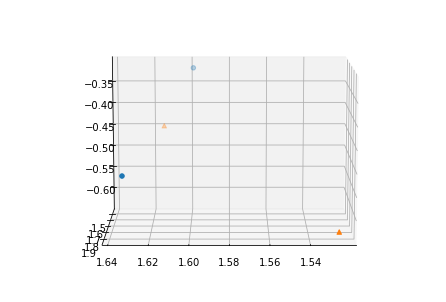

In [60]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d, Axes3D #<-- Note the capitalization! 
import numpy as np

true_value = env.test_data[:2, :3]
predicted_value = np.array(action_dict['agent0'])[:2,:3]
fig = plt.figure()
ax = Axes3D(fig) #<-- Note the difference from your original code...
ax.scatter(xs=true_value[:,:1], ys=true_value[:,1:2], zs=true_value[:,2:3], marker='o')
ax.scatter(xs=predicted_value[:,:1], ys=predicted_value[:,1:2], zs=predicted_value[:,2:3], marker='^')
ax.view_init(elev=10., azim=90)
# for ii in range(0,360,1):
#         ax.view_init(elev=10., azim=ii)
#         fig.savefig("movie/movie%d.png" % ii)
plt.show()